# Robustness of k Nearest Neighbour parameter
## Variation of kNN, internal validation via conductance and coverage
- For CAD cases, clustering is performed for each tissue separately


In [3]:
library(tidyverse)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(clustAnalytics)


options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
tissues <- read.table('OUTPUT_GTEx/Tissue_CADgwas_final', h=F, stringsAsFactors = F)$V1
fold <- "OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/CAD_HARD_clustering/update_corrPCs/variable_kNNpar/"

In [13]:
# compare clustering structure
df_t <- list()
NMI_t <- list()
for(i in 1:length(tissues)){

    tissue <- tissues[i]
    print(tissue)
    file <- sprintf('OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/variable_kNNpar/', tissue)
    out <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', file)))
    df <- list()
    NMI_mat <- matrix(0, ncol = length(out$info_tune$kNN), nrow = length(out$info_tune$kNN))
    rownames(NMI_mat) <- colnames(NMI_mat) <- out$info_tune$kNN
    df_t[[i]] <- out$info_tune %>% mutate(tissues = tissue)
    for(j in 1:length(out$info_tune$kNN)){
     
     cl1 <- out$cl_res[[j]]$cl$membership
     if(j<length(out$info_tune$kNN)){
       for(k in (j+1):length(out$info_tune$kNN)){
         
         cl2 <- out$cl_res[[k]]$cl$membership
         NMI_mat[j, k] <- compare(cl1, cl2, method = 'nmi')
       }
     }
 }
 NMI_mat <- NMI_mat + t(NMI_mat)
 diag(NMI_mat) <- NA
 NMI_t[[i]] <- NMI_mat
}
cl_eval <-  do.call(rbind, df_t)
names(NMI_t) <- tissues

# save
write.table(file = sprintf("%skNN_cluster_eval.txt", fold),
           x = cl_eval, col.names = T, row.names = F, sep = "\t", quote = F)
save(NMI_t, file = sprintf("%skNN_cluster_NMI.RData", fold))

## load
#cl_eval <- read.table(sprintf("%skNN_cluster_eval.txt", fold), header = T, stringsAsFactors = F, sep = "\t")
#NMI_t <- get(load(sprintf("%skNN_cluster_NMI.RData", fold)))

[1] "Adipose_Subcutaneous"
[1] "Adipose_Visceral_Omentum"
[1] "Adrenal_Gland"
[1] "Artery_Aorta"
[1] "Artery_Coronary"
[1] "Colon_Sigmoid"
[1] "Colon_Transverse"
[1] "Heart_Atrial_Appendage"
[1] "Heart_Left_Ventricle"
[1] "Liver"
[1] "Whole_Blood"


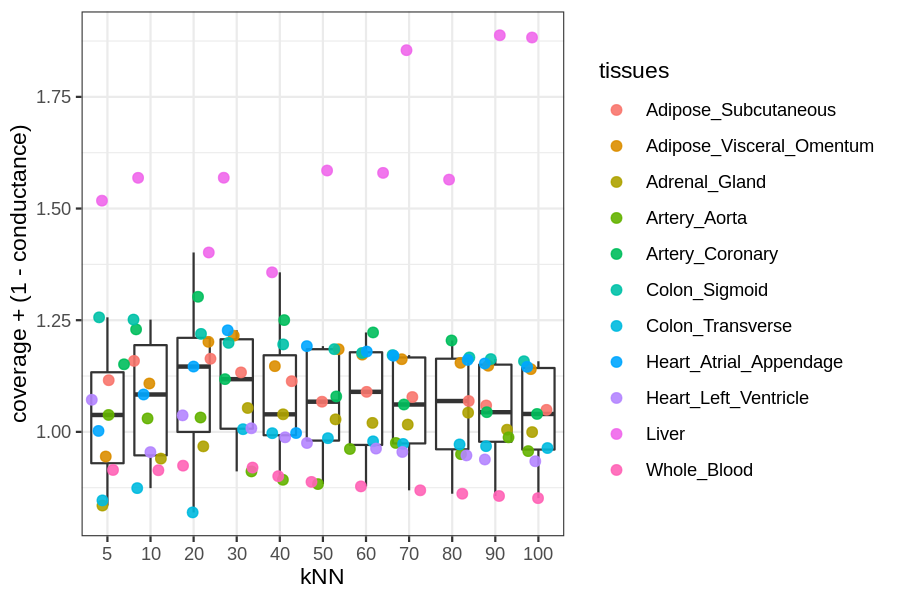

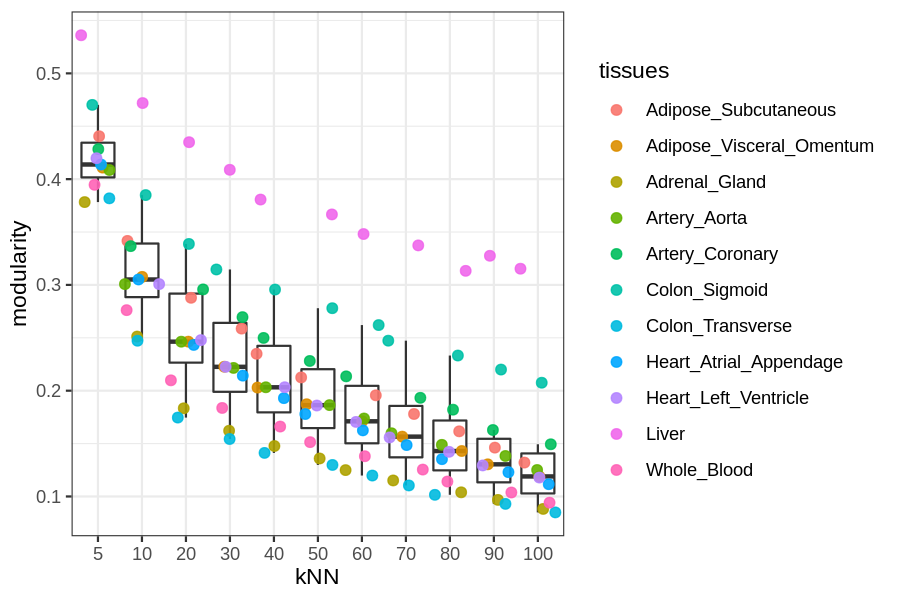

In [14]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 150)

var_names <- c("coverage_and_conductance", "modularity")
# for(var_name in colnames(cl_eval)[2:(ncol(cl_eval) - 1)]){
for(var_name in var_names){
    if(var_name == "coverage_and_conductance"){
        y_title <- c("coverage + (1 - conductance)")
    }else{
        y_title <- var_name
    }
    pl <- ggplot(cl_eval, aes(x = as.factor(kNN), y = get(var_name))) + 
       geom_boxplot(outlier.shape = NA) + 
       geom_jitter(aes(color=tissues), size=2, alpha=0.9) + 
       theme_bw() + 
       ylab(y_title) +
       xlab("kNN") 
    print(pl)
    ggsave(plot = pl, filename = sprintf("%skNN_cluster_%s.pdf", fold, var_name), width = 6, height = 4)
}




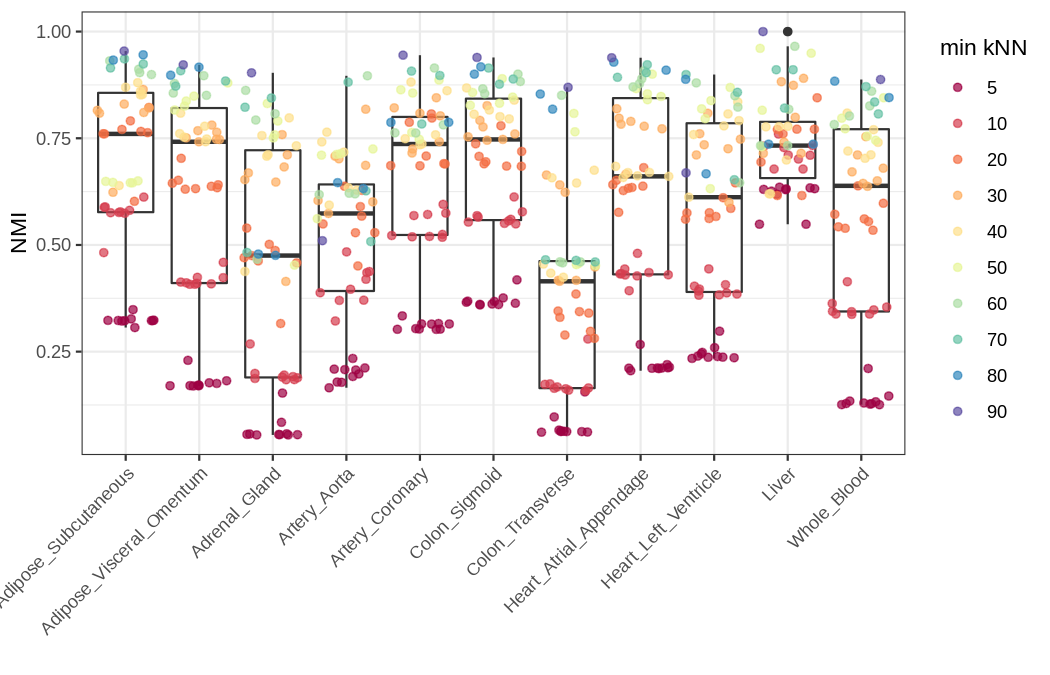

In [15]:
# plot NMI distributions
options(repr.plot.width = 7, repr.plot.height = 4.5, repr.plot.res = 150)
kNN_list <- colnames(NMI_t[[1]])

NMI_df <- lapply(1:length(NMI_t), function(i) 
    data.frame(stringsAsFactors = F, 
    NMI = NMI_t[[i]][lower.tri(x = NMI_t[[i]], diag = F)], 
    tissue = names(NMI_t)[i], 
    min_kNN = unlist(lapply(1:length(kNN_list), function(y) rep(kNN_list[y],length(kNN_list) - y)))))
NMI_df <- do.call(rbind, NMI_df) %>% 
mutate(min_kNN = factor(min_kNN, levels = kNN_list))
                 
pl <- ggplot(NMI_df, aes(x = as.factor(tissue), y = NMI)) + 
       geom_boxplot() + 
       geom_jitter(aes(color = min_kNN), alpha = 0.7) +
       theme_bw() + 
       theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
       xlab("") +
       scale_color_brewer(name = "min kNN", palette = "Spectral")
pl
ggsave(plot = pl, filename = sprintf("%skNN_cluster_pairwiseNMI.pdf", fold), width = 7, height = 4.5)        

corrplot 0.92 loaded



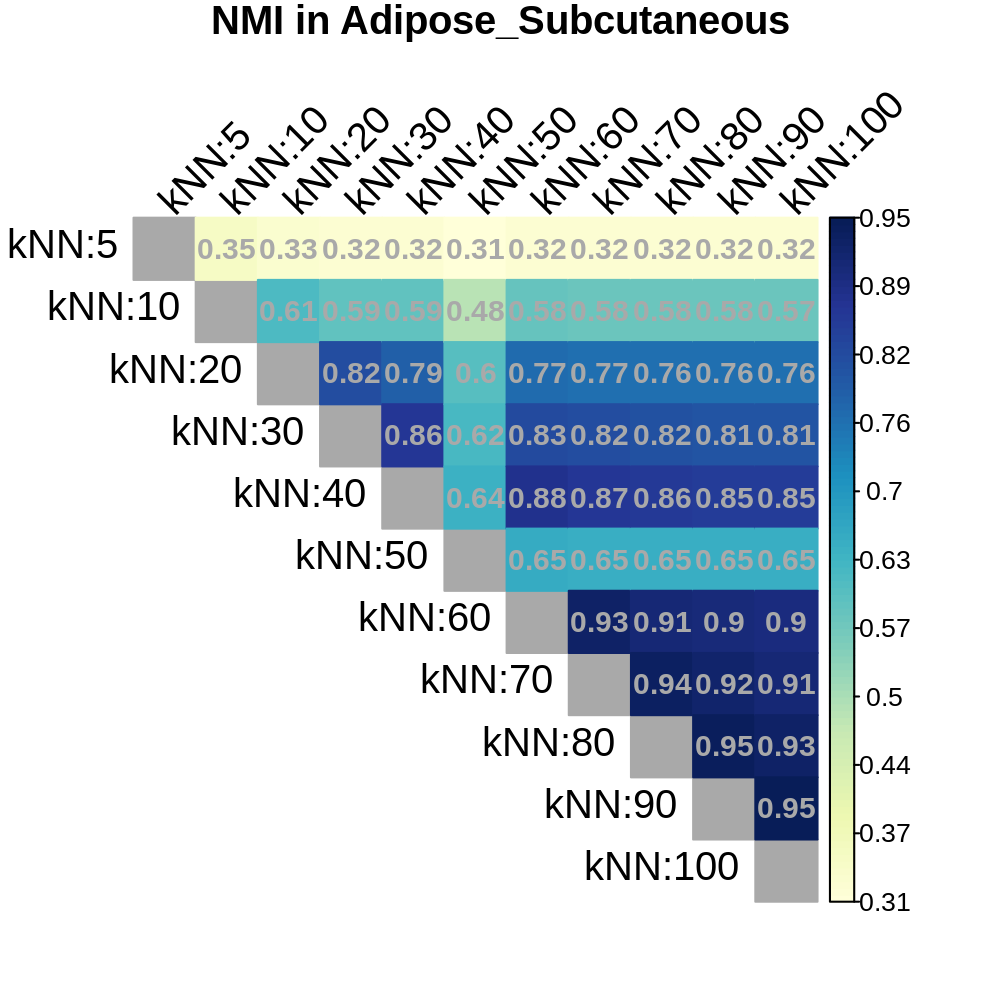

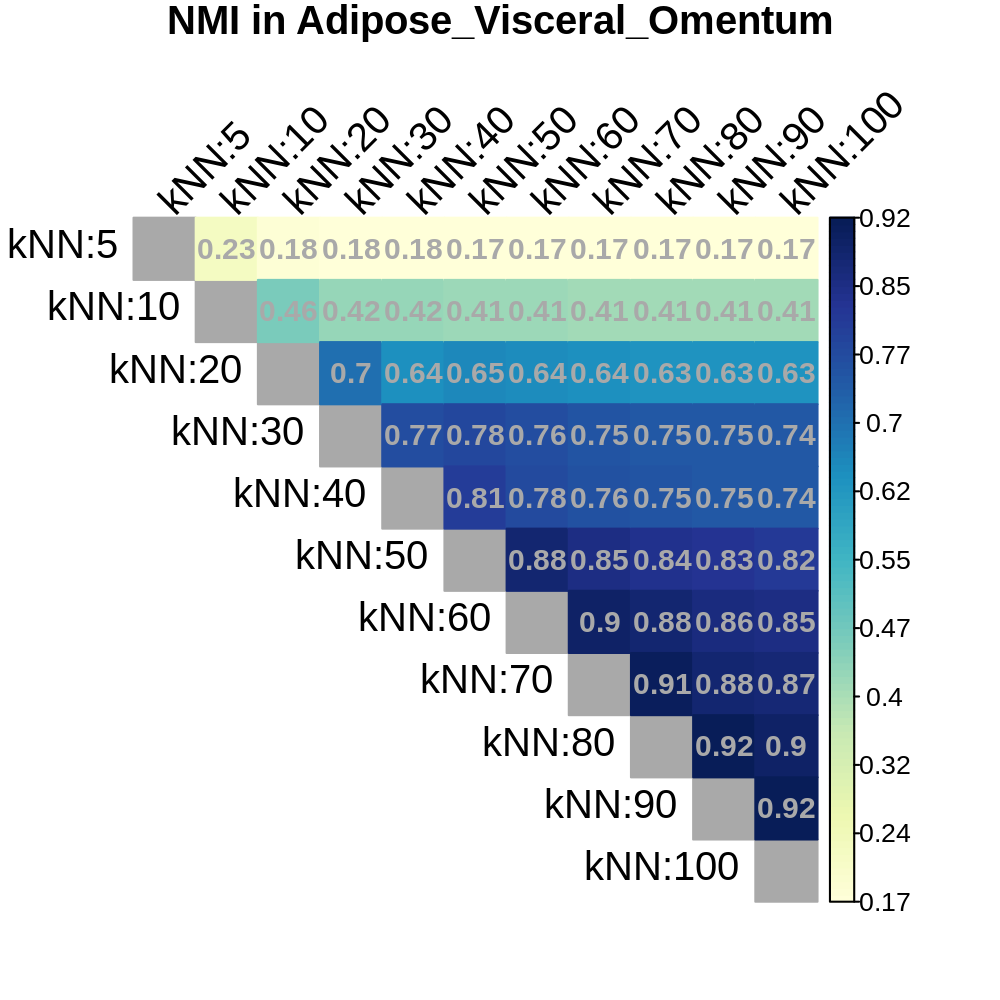

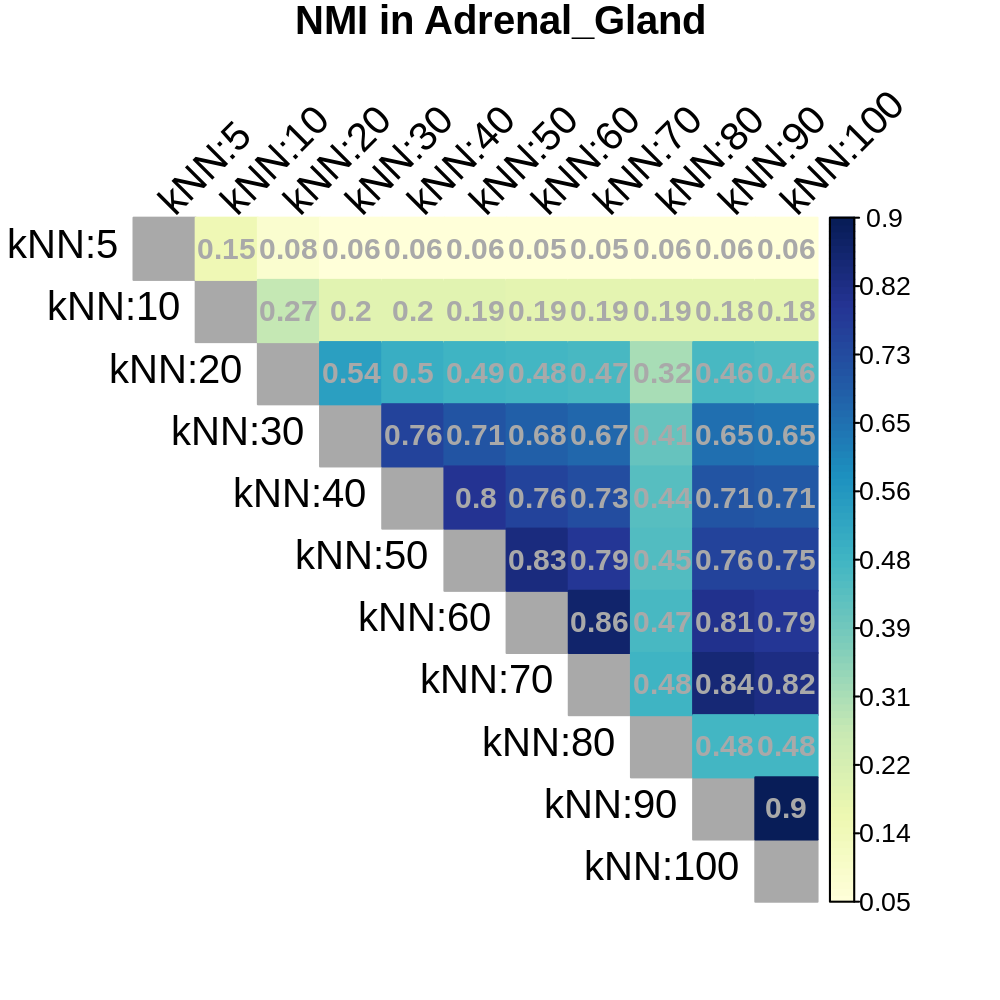

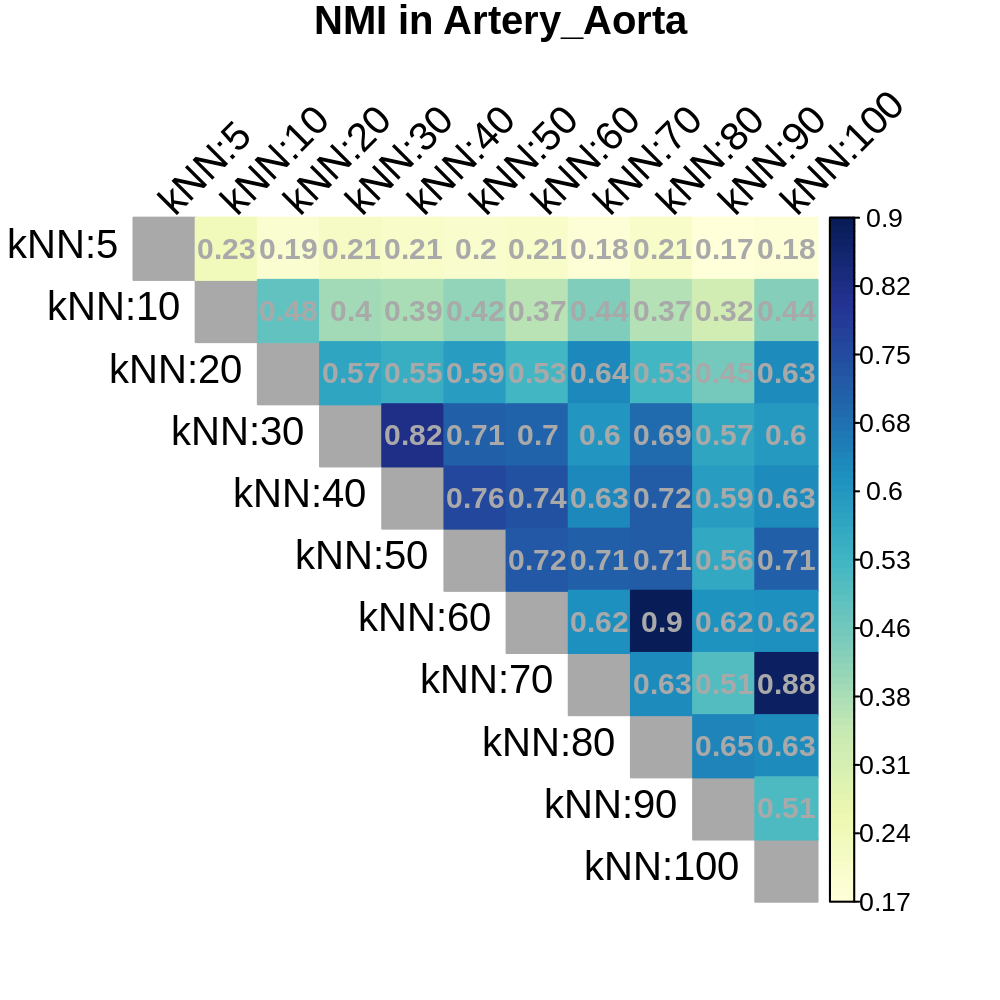

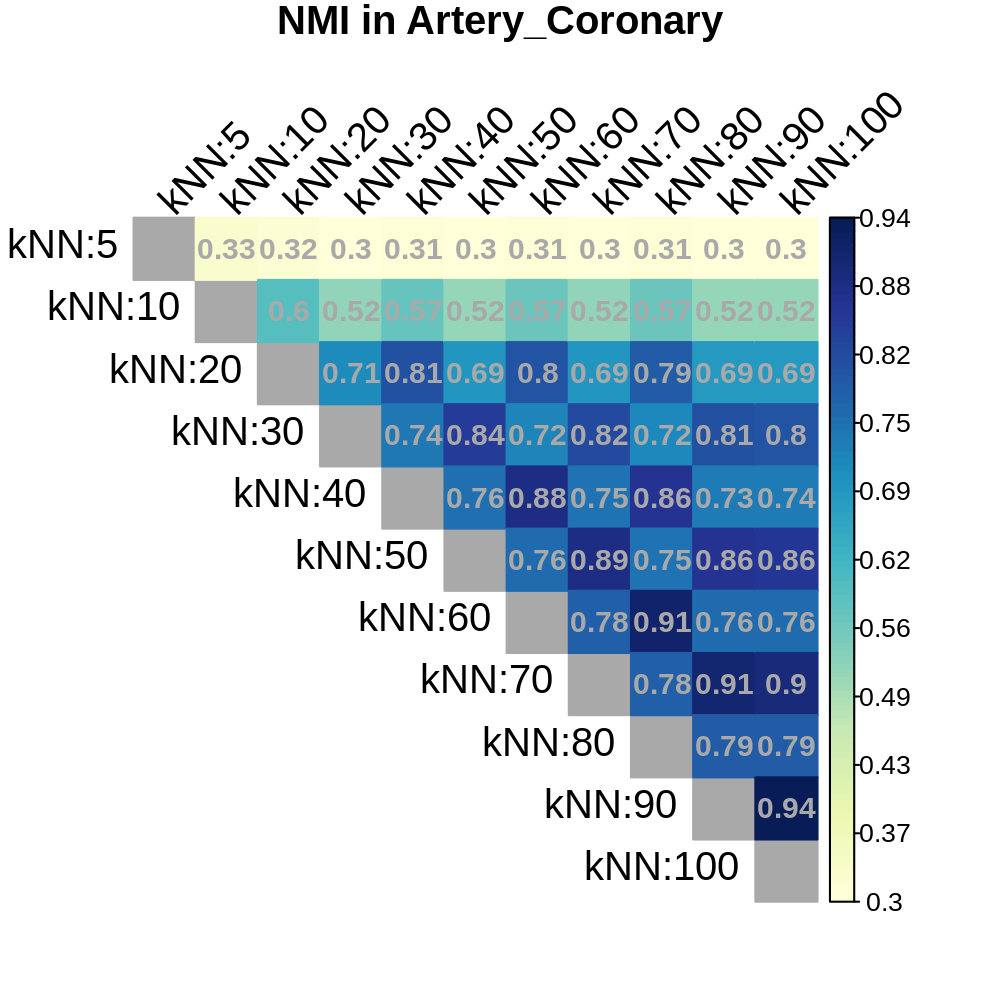

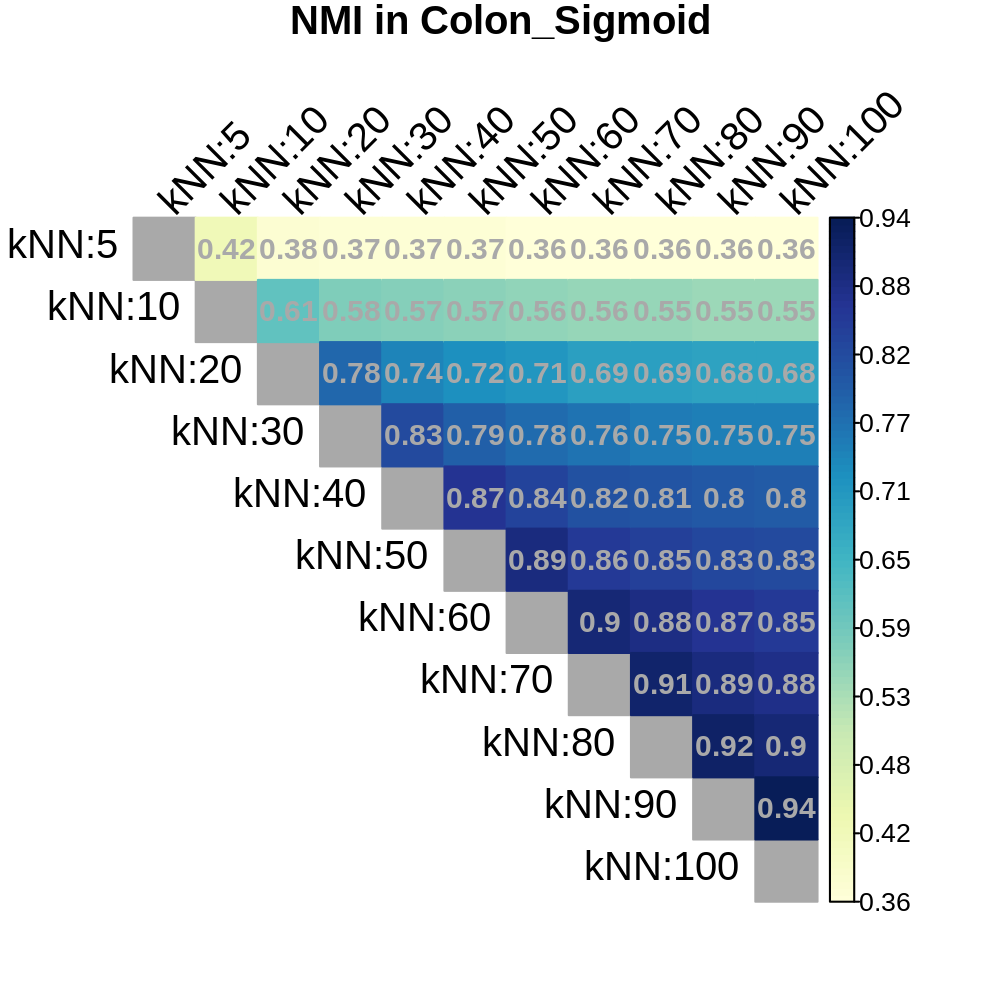

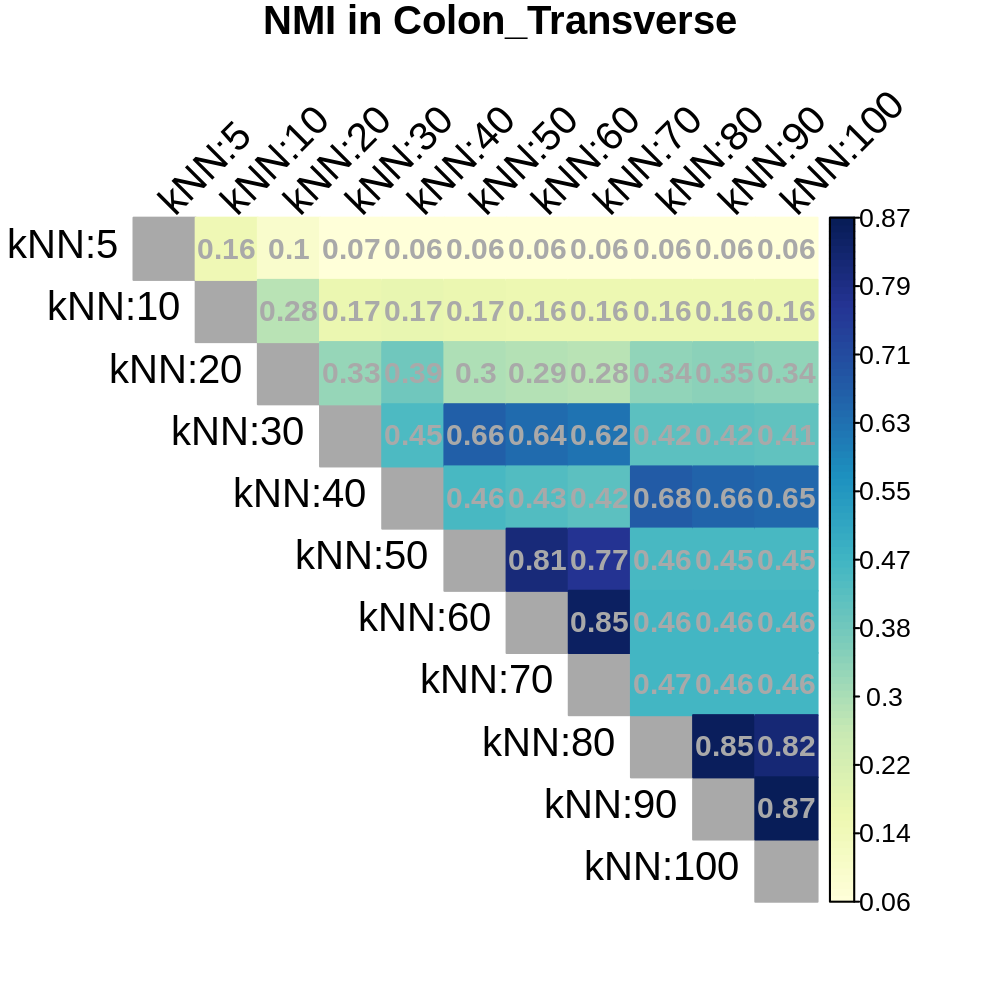

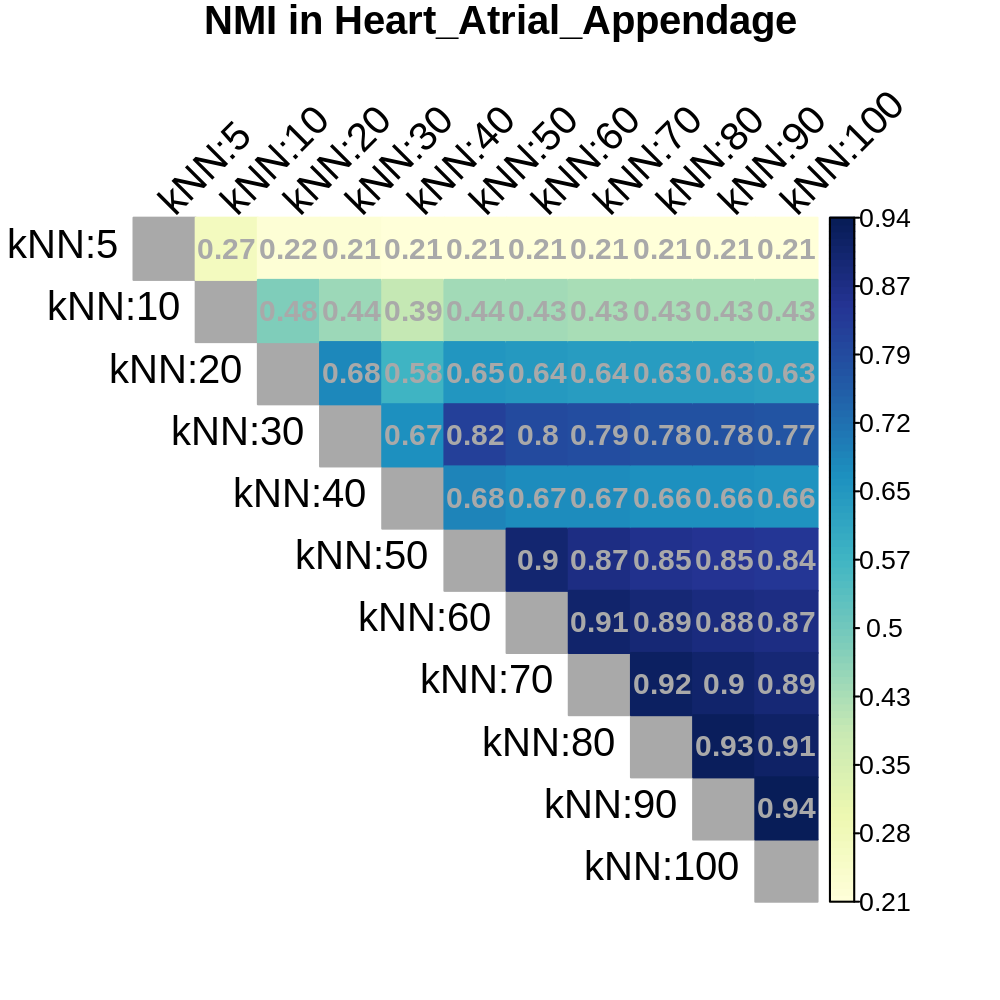

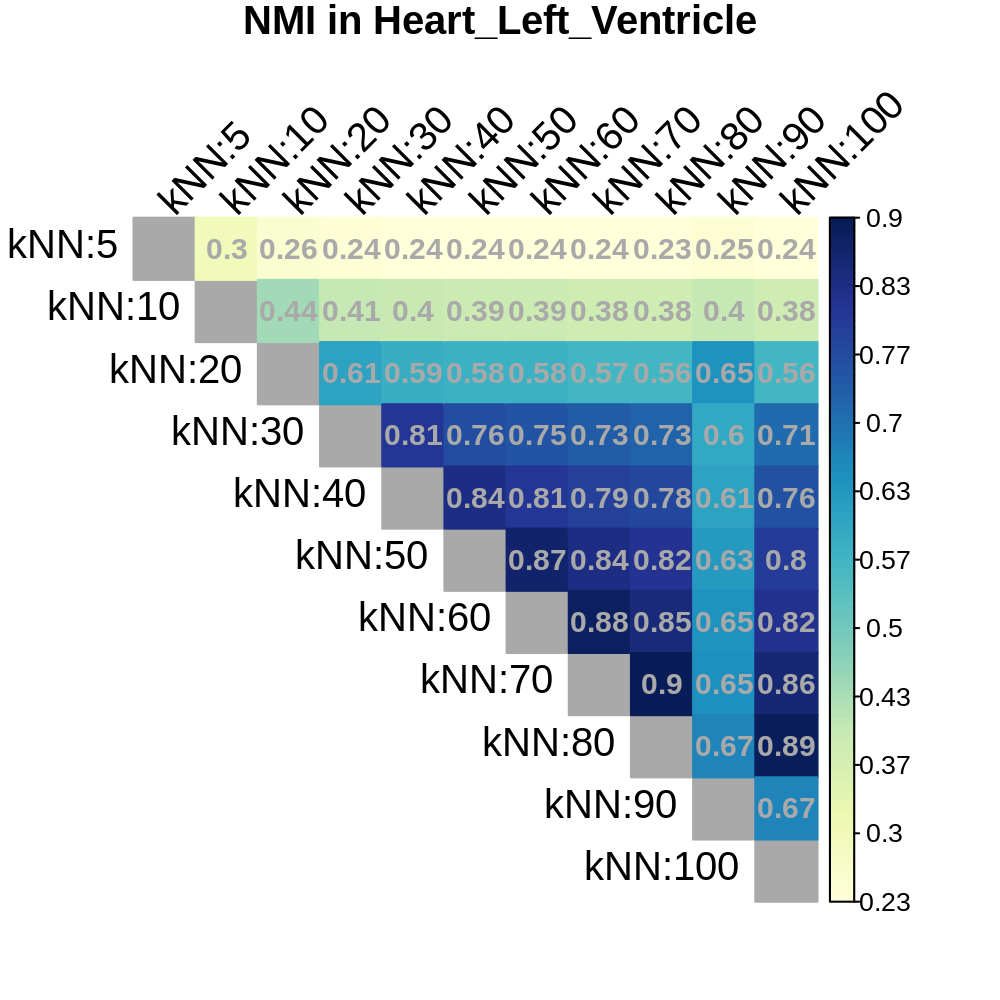

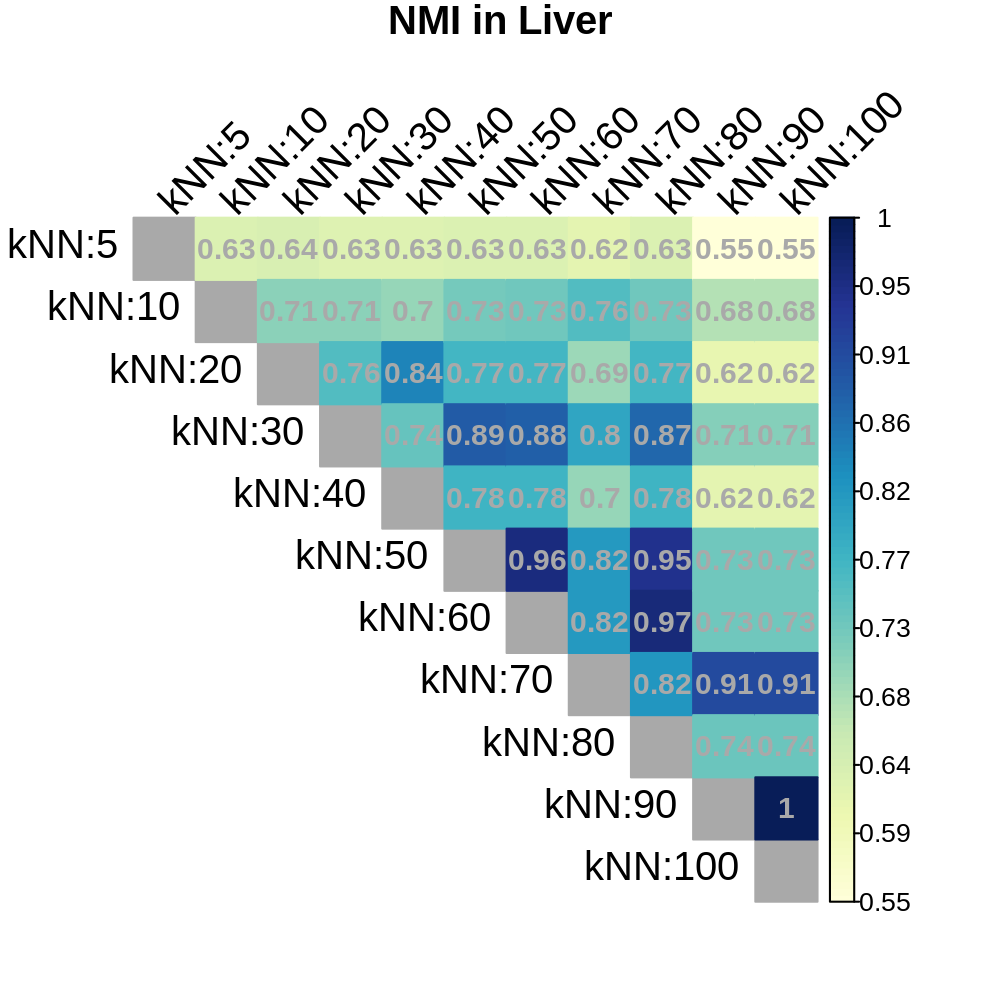

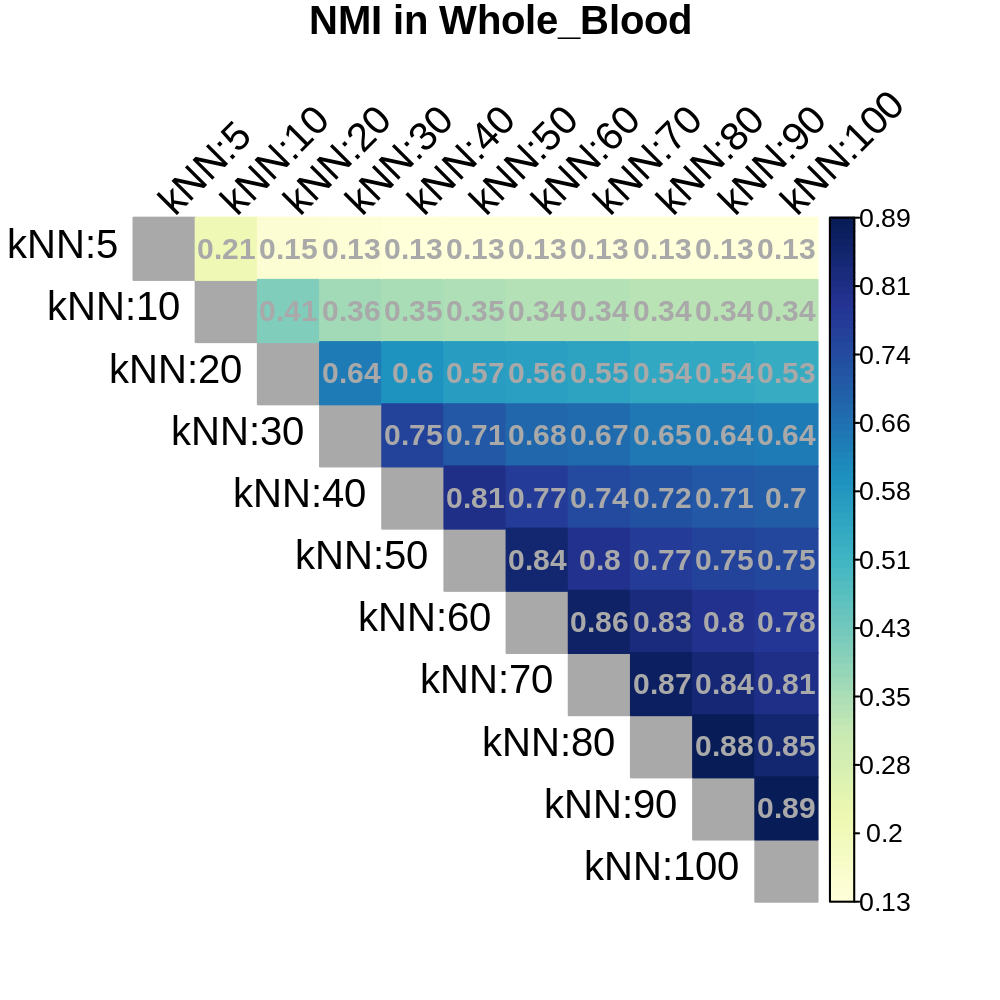

In [16]:
### plot NMI in heatmap ###
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
library(RColorBrewer)
library(corrplot)
col <- colorRampPalette(brewer.pal(9, 'YlGnBu'))(100)

for(i in 1:length(tissues)){
    tissue <- tissues[i]
    title_pl <- sprintf('NMI in %s', tissue)
    tmp <- NMI_t[[i]]
    colnames(tmp) <- paste0("kNN:", colnames(NMI_t[[i]]))
    rownames(tmp) <- paste0("kNN:", rownames(NMI_t[[i]]))

    corrplot(tmp, type="upper", title = title_pl,
         tl.cex=1.2,
         tl.col = "black",
         col = c(col), method = 'color', tl.srt=45, cl.align.text='c',
         addCoef.col = "darkgrey",na.label = 'square', na.label.col = 'darkgrey', 
         is.corr = F, number.cex=0.9, mar = c(0,0,1,0))
}


## For a fixed kNN = 20, compute cluster robustness from 50% bootstrap

In [38]:
n_rep <- 10
idkNN_20 <- which(kNN_list == 20)
NMI_t <- list()
df_t <- list()
for(i in 1:length(tissues)){
    tissue <- tissues[i]
    print(tissue)
    file <- sprintf('OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/variable_kNNpar/', tissue)
    out_original <- get(load(sprintf('%s/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', file)))
    df_t[[i]] <- out_original$info_tune %>% 
        filter(kNN == 20) %>%
        mutate(type = "original") 
    out_bs <- list()
    NMI_tmp <- vector("numeric", length = n_rep)
    for(j in 1:n_rep){
        out_bs <- get(load(sprintf('%s/bootstrap50_rep%i_kNN20_tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', file, j)))
        df_t[[i]] <- rbind(df_t[[i]], out_bs$info_tune %>% mutate(type = sprintf("bootstrap_rep%i", j)))

        samples_id <- out_bs$cl_best$id
        common_id <- match(samples_id, out_original$samples_id)
        NMI_tmp[j] <- igraph::compare(out_bs$cl_best$gr, out_original$cl_res[[idkNN_20]]$cl$membership[common_id], method = "nmi")
    }   
    NMI_t[[i]] <- data.frame(NMI = NMI_tmp, type = paste0("bootstrap_rep", 1:n_rep), tissue = tissue)
    df_t[[i]] <- df_t[[i]] %>% mutate(tissue = tissue)
}

cl_eval_bs <-  do.call(rbind, df_t)
cl_NMI_bs <- do.call(rbind, NMI_t) 

[1] "Adipose_Subcutaneous"
[1] "Adipose_Visceral_Omentum"
[1] "Adrenal_Gland"
[1] "Artery_Aorta"
[1] "Artery_Coronary"
[1] "Colon_Sigmoid"
[1] "Colon_Transverse"
[1] "Heart_Atrial_Appendage"
[1] "Heart_Left_Ventricle"
[1] "Liver"
[1] "Whole_Blood"


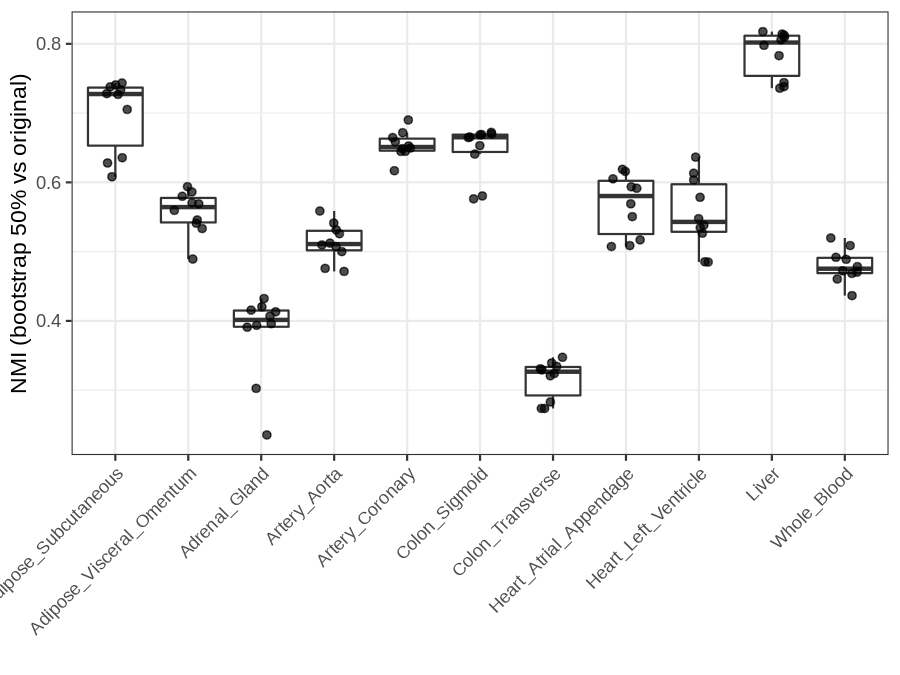

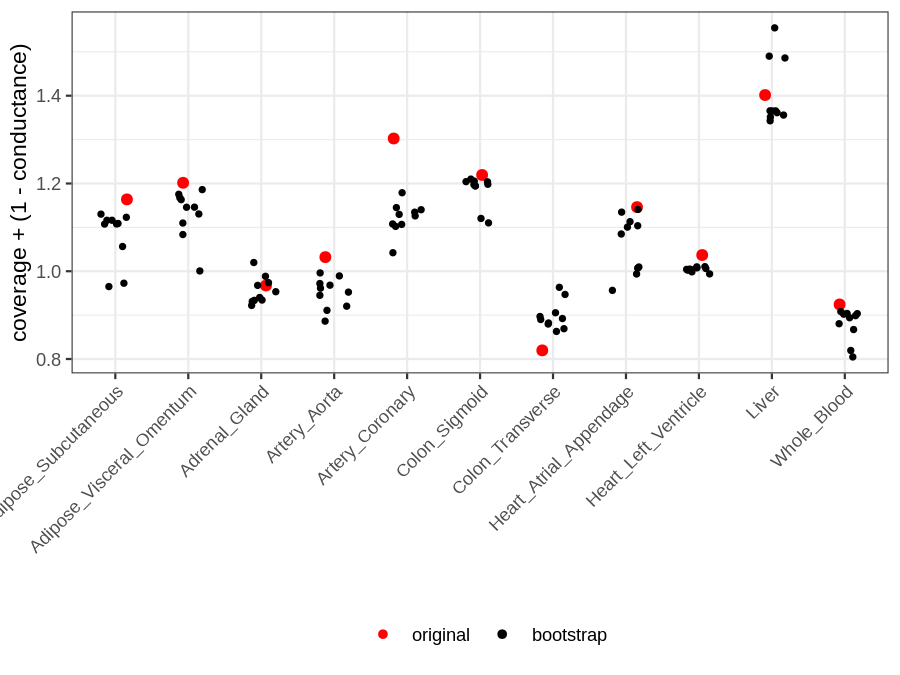

In [47]:
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 150)

# plot NMI distributions
pl <- ggplot(cl_NMI_bs, aes(x = as.factor(tissue), y = NMI)) + 
       geom_boxplot(outlier.shape = NA) + 
       geom_jitter(alpha = 0.7, width = 0.2) +
       theme_bw() + 
       theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
       xlab("") + ylab("NMI (bootstrap 50% vs original)")
pl
ggsave(plot = pl, filename = sprintf("%skNN20_bootstrap50_NMIwithOriginal.pdf", fold), width = 6, height = 4.5)        

# plot cluster eval
cl_eval_bs <- cl_eval_bs %>%
       mutate(type_v2 = case_when(type == "original" ~ "original",
                                  TRUE ~ "bootstrap")) %>%
       mutate(type_v2 = factor(type_v2, levels = c("original", "bootstrap")))

pl <- ggplot(cl_eval_bs, aes(x = as.factor(tissue), y = coverage_and_conductance)) + 
       # geom_boxplot() + 
       geom_jitter(aes(color = type_v2, size = type_v2), width = 0.2) +
       theme_bw() + 
       theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "bottom") + 
       xlab("") + 
       ylab("coverage + (1 - conductance)") +
       scale_color_manual(name = "", values = c("red", "black")) +
       scale_size_manual(name = "", values = c(2, 1), guide = "none")

pl
ggsave(plot = pl, filename = sprintf("%skNN20_bootstrap50_coverage_and_conductance.pdf", fold), width = 6, height = 4.7)      


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



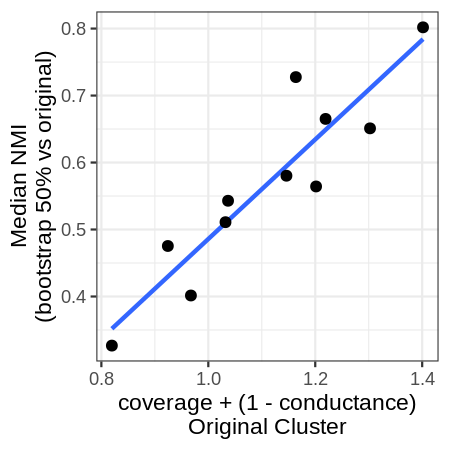

In [57]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 150)
# plot relationship cl eval and average NMI with original
df <- data.frame(
    coverage_and_conductance_original = cl_eval_bs$coverage_and_conductance[cl_eval_bs$type_v2 == "original"], 
    median_NMI = cl_NMI_bs %>% group_by(tissue) %>% summarize(m = median(NMI)) %>% pull(m)
)

pl <- ggplot(df, aes(x = coverage_and_conductance_original, y = median_NMI)) + 
       theme_bw() + 
       geom_smooth(method = "lm", se = F, alpha = 0.5) +
       geom_point(size = 2) +
       xlab("coverage + (1 - conductance)\nOriginal Cluster") + 
       ylab("Median NMI\n(bootstrap 50% vs original)")
pl
ggsave(plot = pl, filename = sprintf("%skNN20_bootstrap50_coverage_and_conductance_VS_NMIwithOriginal.pdf", fold), width = 3, height = 3)  

## Conclusions:
- we tested different kNN parameters, across tissues the results in terms of coverage (to be maximized) and conductance (to be minimized) are rathr stable (except for kNN = 5) and median results are best for kNN = 20.
- the similarity for each pairwise combination in a tissue is variable, but we always get a more different configuration for kNN = 5
- fixing kNN = 20, we performed a bottstrap of 50% and run the clustering with the same parameters. The NMI with original clustering is variable per tissue, with Liver and AS getting the best results. We also noticed that the robustness is dependent on the clustering quality of that tissue. Indeed, the cluster quality (coverage and conductance) is rather stable when comparing the bootstrap and original clustering